# Facial Expression Challenge

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
import random

matplotlib.style.use('ggplot')
%matplotlib inline

# Describe the Data

In [2]:
df = pd.read_csv("training/fer2013.csv")
print(df.head())
print("Number of unique Emotions: %s" % (df.emotion.unique()))

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
Number of unique Emotions: [0 2 4 6 3 5 1]


# Helper Functions

In [3]:
# pixels is the series from the Dataframe
def extract_from_string(pixels):
    pixels = pixels.split(' ')
    pixels = np.array([int(i) for i in pixels])
    return np.reshape(pixels, (48, 48))    

def extract_image(pixels):
    pixels = pixels.as_matrix()[0] # The output is a string
    return extract_from_string(pixels)

# Overview of the images

In [209]:
def overview(total_rows, df):
    fig = plt.figure(figsize=(8,10))
    idx = 0
    for i, row in df.iterrows():
        input_img = extract_from_string(row.pixels)
        ax = fig.add_subplot(16,12,idx+1)
        ax.imshow(input_img, cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
        idx += 1
    plt.show()

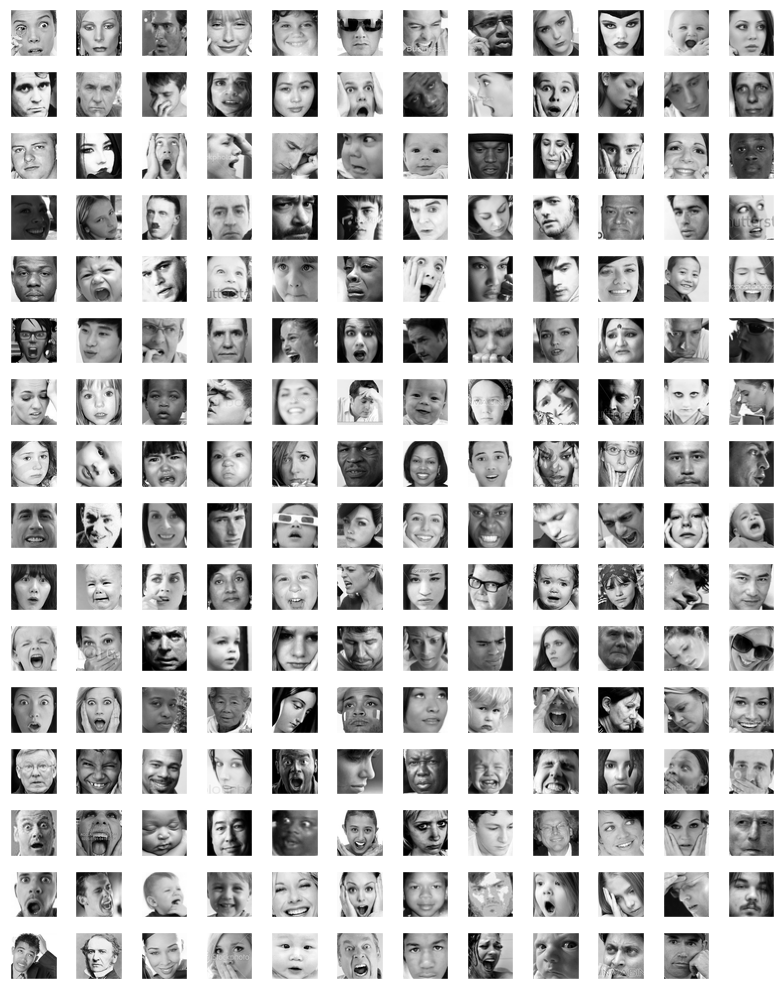

In [214]:
num_images = 191
df = df.sample(n=num_images)
overview(num_images, df) # overview of face data as thumbnails (private)

# Display one unique Emotion

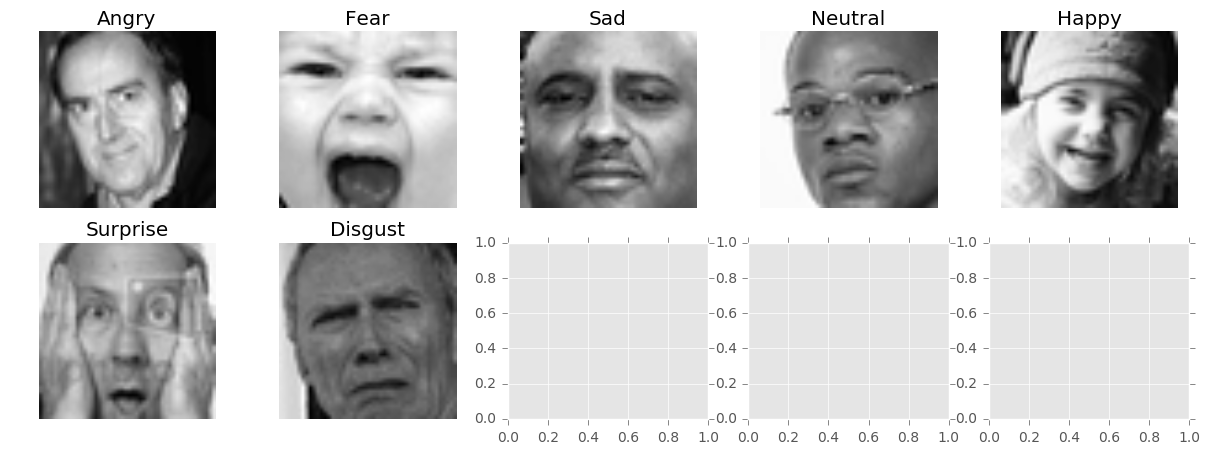

In [4]:
emotion_description = {0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"}

unique_emotions = df.emotion.unique()
images = []
emotions = []
for emotion in unique_emotions:
    emotion_df = df[df.emotion == emotion].sample(n=1)
    images.append(extract_image(emotion_df.pixels))
    emotions.append(emotion)

cols = 5
fig, ax = plt.subplots(len(images) // cols + 1, cols, figsize=(15, 5))
global_img = None
for i,img in enumerate(images):
    row = i // cols
    col = i % cols
    ax[row, col].imshow(img, cmap='gray')
    ax[row, col].axis('off')
    ax[row, col].set_title(emotion_description[emotions[i]])
    global_img = img

# Data Distribution

0    4953
1     547
2    5121
3    8989
4    6077
5    4002
6    6198
Name: emotion, dtype: int64


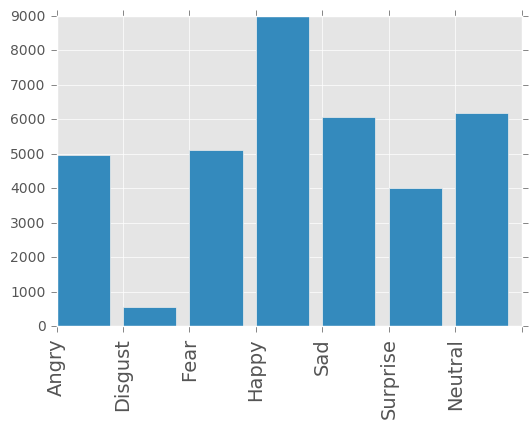

In [5]:
value_counts = df['emotion'].value_counts().sort_index()
ax = plt.subplot()
x_ticks_labels = [emotion_description[i] for i in range(len(value_counts))]
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=14)
ax.bar(range(0, len(value_counts)), value_counts)
print(value_counts)

# Use Image Augmentation to Augment the dataset

In [6]:
from scipy import ndimage
from scipy.misc import imresize
from skimage import data, io, filters
from skimage.transform import swirl

import cv2

# Image Augmentation Techniques

In [7]:
def display_side_by_side(img1, img2):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img1, cmap='gray')
    ax[0].axis('off')
    ax[1].imshow(img2, cmap='gray')
    ax[1].axis('off')    

In [8]:
def ogrid(img):
    nimg = np.copy(img)
    lx, ly = nimg.shape
    X, Y = np.ogrid[0:lx, 0:ly]
    mask = (X - lx / 2) ** 2 + (Y - ly / 2) ** 2 > lx * ly / 4
    nimg[mask] = 0
    return nimg

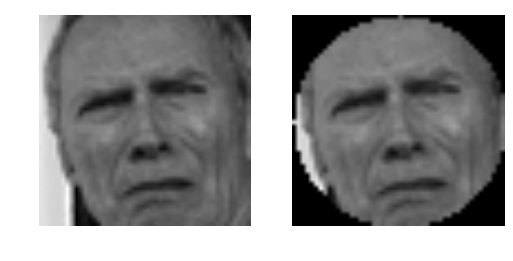

In [9]:
nimg = ogrid(global_img)
display_side_by_side(global_img, nimg)

In [10]:
def rotate_img(img):
    angle = np.random.choice(np.random.uniform(-45,45,100))
    nimg = np.copy(img)
    nimg = ndimage.rotate(nimg, angle)
    height, width = img.shape
    nimg = imresize(nimg, (width, height))
    return nimg

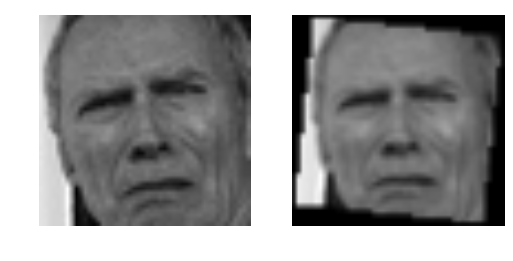

In [11]:
nimg = rotate_img(global_img)
display_side_by_side(global_img, nimg)

In [12]:
def blur_img(img):
    nimg = np.copy(img)
    sigma = np.random.randint(1, 2)
    blurred_img = ndimage.gaussian_filter(nimg, sigma=sigma)
    return blurred_img

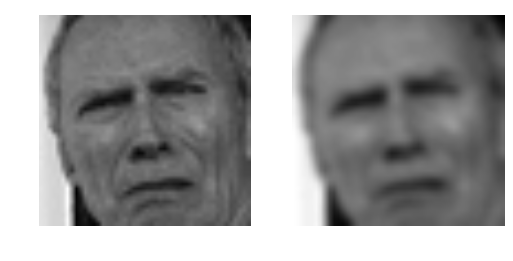

In [13]:
nimg = blur_img(global_img)
display_side_by_side(global_img, nimg)

In [14]:
def flip_img(img):
    nimg = np.copy(img)
    nimg = np.fliplr(nimg)
    return nimg

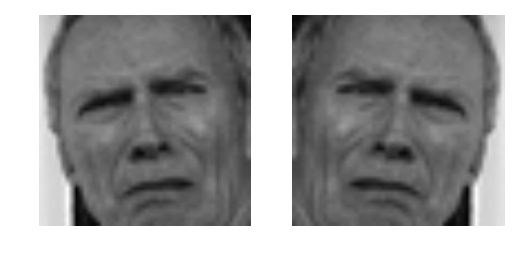

In [15]:
nimg = flip_img(global_img)
display_side_by_side(global_img, nimg)

In [16]:
def add_noise(img):
    nimg = np.copy(img)
    noise = np.random.normal(0,0.5,size=(48, 48)).astype(np.uint8) * 255
    nimg += noise
    nimg = np.clip(nimg, 0, 255)
    return nimg

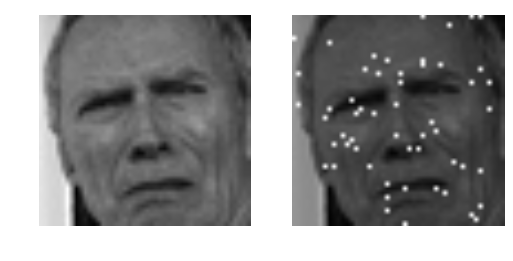

In [17]:
nimg = add_noise(global_img)
display_side_by_side(global_img, nimg)

In [18]:
def augment_img(img):
    methods = [ogrid, rotate_img, blur_img, flip_img, add_noise]

    method = np.random.choice(methods)
    return method(img)

In [19]:
max_value = df['emotion'].value_counts().max()
max_idx = df['emotion'].value_counts().idxmax()
print(max_idx, max_value)

3 8989


# Convert the pixels from the Dataframe into actual images

In [20]:
new_df = pd.DataFrame()
for i, row in df.iterrows():
    # Take this row and convert its pixel type to actual image
    new_df = new_df.append(pd.Series([row.emotion, extract_from_string(row.pixels), row.Usage], index=['emotion', 'pixels', 'Usage'], name=str(i)))
    
print(new_df)

             Usage  emotion                                             pixels
0         Training      0.0  [[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, ...
1         Training      0.0  [[151, 150, 147, 155, 148, 133, 111, 140, 170,...
2         Training      2.0  [[231, 212, 156, 164, 174, 138, 161, 173, 182,...
3         Training      4.0  [[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, ...
4         Training      6.0  [[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 2...
5         Training      2.0  [[55, 55, 55, 55, 55, 54, 60, 68, 54, 85, 151,...
6         Training      4.0  [[20, 17, 19, 21, 25, 38, 42, 42, 46, 54, 56, ...
7         Training      3.0  [[77, 78, 79, 79, 78, 75, 60, 55, 47, 48, 58, ...
8         Training      3.0  [[85, 84, 90, 121, 101, 102, 133, 153, 153, 16...
9         Training      2.0  [[255, 254, 255, 254, 254, 179, 122, 107, 95, ...
10        Training      0.0  [[30, 24, 21, 23, 25, 25, 49, 67, 84, 103, 120...
11        Training      6.0  [[39, 75, 78, 58, 58, 4

# Make all the Image categories the same size

In [21]:
augmented_df = new_df.copy()
unique_emotions = new_df.emotion.unique()
for emotion in unique_emotions:
    if emotion != max_idx:
        # This is the dataset we want to augment
        # Find the current length of this emotion
        emotion_df = augmented_df[augmented_df.emotion == emotion]
        current_size = len(emotion_df)
        images_2_generate = max_value - current_size
        for i in range(0, images_2_generate):
            # Choose a random image
            emotion_df = augmented_df[augmented_df.emotion == emotion].sample(n=1)
            current_img = emotion_df.pixels[0]
            nimg = augment_img(current_img)
            
            # Add a new row
            row = pd.Series([emotion, nimg, "Training"], index=["emotion", "pixels", "Usage"], name=str(i))
            augmented_df = augmented_df.append(row)

# New Data Distribution

0.0    8989
1.0    8989
2.0    8989
3.0    8989
4.0    8989
5.0    8989
6.0    8989
Name: emotion, dtype: int64


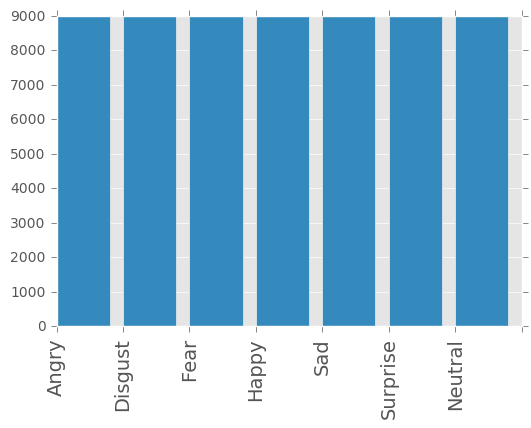

In [22]:
value_counts = augmented_df['emotion'].value_counts().sort_index()
ax = plt.subplot()
x_ticks_labels = [emotion_description[i] for i in range(len(value_counts))]
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=14)
ax.bar(range(0, len(value_counts)), value_counts)
print(value_counts)

# Network

In [96]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Lambda, Activation
from keras.layers import Conv2D, MaxPooling2D, concatenate, Input
from keras.callbacks import TensorBoard
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback
from keras.utils import np_utils

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [93]:
class LeNet:
    @staticmethod
    def build(width, height, depth, classes, weightsPath=None):
        model = Sequential()
        # First set Conv Layers
        model.add(Conv2D(64, (3, 3), padding='valid', input_shape=(width, height, depth), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())

        # 2nd set Conv layers
        model.add(Conv2D(128, (3, 3), padding='valid', input_shape=(width, height, depth), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(256, (3, 3), padding='valid', activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(512, (3, 3), padding='valid', activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # Set of FC => Relu layers
        model.add(Flatten())
        model.add(Dense(256))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))

        # Softmax classifier
        model.add(Dense(classes))
        model.add(Activation('softmax'))

        if weightsPath is not None:
            model.load_weights(weightsPath)

        return model

In [176]:
model = LeNet.build(48, 48, 1, 7)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
generator = ImageDataGenerator( featurewise_center=True,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False,
                            rotation_range=20.,
                            width_shift_range=0.4,
                            height_shift_range=0.4,
                            shear_range=0.2,
                            zoom_range=0.2,
                            channel_shift_range=0.1,
                            fill_mode='nearest',
                            horizontal_flip=True,
                            vertical_flip=False,
                            rescale=1.2,
                            preprocessing_function=None)

train_df = augmented_df[augmented_df.Usage == "Training"]
test_df = augmented_df[augmented_df.Usage == "PrivateTest"]

trainData = np.array(train_df.pixels, dtype=pd.Series)
trainLabels = np.array(train_df.emotion, dtype=pd.Series)
trainLabels = np_utils.to_categorical(trainLabels, 7)


testData = np.array(train_df.pixels, dtype=pd.Series)
testLabels = np.array(train_df.emotion, dtype=pd.Series)
testLabels = np_utils.to_categorical(testLabels, 7)

td = []
for t in trainData:
    t = np.reshape(t, (48, 48, 1))
    td.append(t)
    
tl = []
for t in trainLabels:
    tl.append(t)

trainData = np.array(td)
trainLabels = np.array(tl)

trainData, trainLabels = shuffle(trainData, trainLabels)

td = []
for t in testData:
    t = np.reshape(t, (48, 48, 1))
    td.append(t)
    
tl = []
for t in testLabels:
    tl.append(t)

testData = np.array(td)
testLabels = np.array(tl)


generator.fit(trainData)
filepath = "lenet.best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
batch_size = 128

use_augmentation = False
if use_augmentation:
    trainData, validationData, trainLabels, validationLabels = train_test_split(trainData, trainLabels, test_size=0.2, random_state=20)
    hist = model.fit_generator(generator.flow(trainData, trainLabels, batch_size=batch_size),
                          steps_per_epoch= int(len(trainData) / batch_size + 1),
                          epochs=200,
                          verbose=1,
                          validation_data=(validationData, validationLabels),
                          callbacks=[TensorBoard(log_dir='logs'), checkpoint, TQDMNotebookCallback(leave_inner=False, leave_outer=True)])
else:
    hist = model.fit(trainData, trainLabels, epochs=50, batch_size=batch_size,
              validation_split=0.2, callbacks=[TensorBoard(log_dir='logs'), checkpoint, TQDMNotebookCallback(leave_inner=False, leave_outer=True)], shuffle=True, verbose=1)

Train on 44596 samples, validate on 11149 samples
Epoch 1/50
44596/44596 [==============================] - 15s - loss: 1.9505 - acc: 0.3242 - val_loss: 1.5514 - val_acc: 0.4072
Epoch 2/50
44596/44596 [==============================] - 12s - loss: 1.4342 - acc: 0.4588 - val_loss: 1.2875 - val_acc: 0.5084
Epoch 3/50
44596/44596 [==============================] - 12s - loss: 1.2698 - acc: 0.5206 - val_loss: 1.2496 - val_acc: 0.5289
Epoch 4/50
44596/44596 [==============================] - 12s - loss: 1.1534 - acc: 0.5681 - val_loss: 1.2182 - val_acc: 0.5438
Epoch 5/50
44596/44596 [==============================] - 12s - loss: 1.0538 - acc: 0.6053 - val_loss: 1.0992 - val_acc: 0.5961
Epoch 6/50
44596/44596 [==============================] - 12s - loss: 0.9643 - acc: 0.6407 - val_loss: 1.0834 - val_acc: 0.5935
Epoch 7/50
44596/44596 [==============================] - 12s - loss: 0.8681 - acc: 0.6772 - val_loss: 1.1228 - val_acc: 0.5957
Epoch 8/50
44596/44596 [==============================

In [183]:
from keras.models import load_model

model = load_model('lenet.best.h5')

y_prob = model.predict(testData, batch_size=32, verbose=0)
y_pred = [np.argmax(prob) for prob in y_prob]
y_true = [np.argmax(true) for true in testLabels]

output = open('prediction.csv', 'w')
for p in y_pred:
    output.write(str(p))
    output.write("\n")

output.close()

In [184]:
def plot_subjects(start, end, y_pred, y_true, title=False):
    fig = plt.figure(figsize=(12,12))
    emotion = {0:'Angry', 1: "Disgust", 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
    for i in range(start, end+1):
        input_img = testData[i:(i+1),:,:,:]
        input_img = np.reshape(input_img, (48, 48))
        ax = fig.add_subplot(6,6,i+1)
        ax.imshow(input_img, cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        if y_pred[i] != y_true[i]:
            plt.xlabel("P: " + emotion[y_pred[i]] + " A: " + emotion[y_true[i]], color='#53b3cb',fontsize=10)
        else:
            plt.xlabel("P: " + emotion[y_pred[i]] + " A: " + emotion[y_true[i]], fontsize=10)
        if title:
            plt.title(emotion[y_pred[i]], color='blue')
        plt.tight_layout()
    plt.show()

In [200]:
def plot_probs(start,end, y_prob):
    fig = plt.figure(figsize=(12,12))
    color_set = ('.00', '.25', '.50', '.75')
    for i in range(start, end+1):
        ax = fig.add_subplot(6,6,i+1)
        # color_list = [color_set[(len(color_set) * int(val * 100)) // 100] for val in y_prob[i]]
        ax.bar(np.arange(0,7), y_prob[i], alpha=0.5)
        ax.set_xticks(np.arange(0.5,7.5,1))
        labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise','neutral']
        ax.set_xticklabels(labels, rotation=90, fontsize=10)
        ax.set_yticks(np.arange(0.0,1.1,0.5))
        plt.tight_layout()
    plt.show()

In [201]:
def plot_subjects_with_probs(start, end, y_prob):
    iter = (end - start)//7
    for i in np.arange(0,iter):
        plot_subjects(i*6,(i+1)*6-1, y_pred, y_true, title=False)
        plot_probs(i*6,(i+1)*6-1, y_prob)

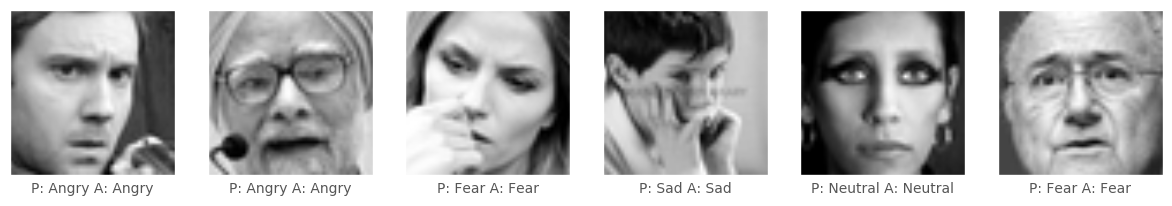

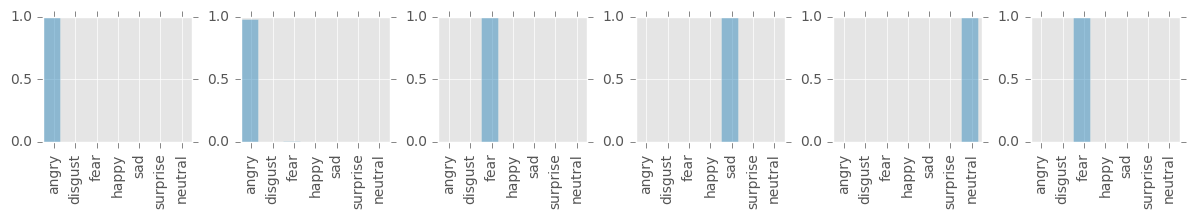

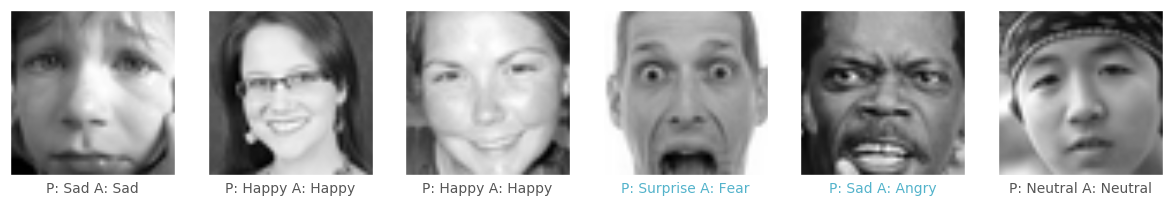

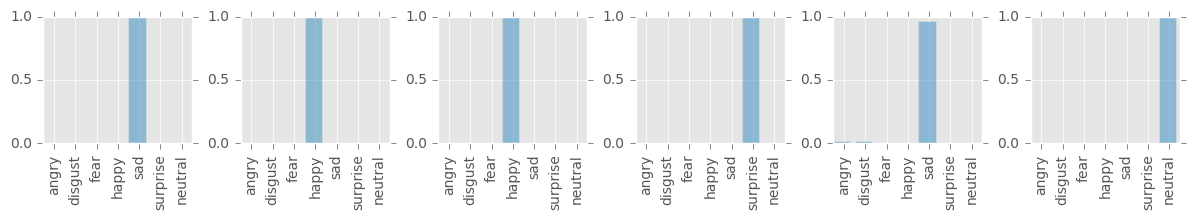

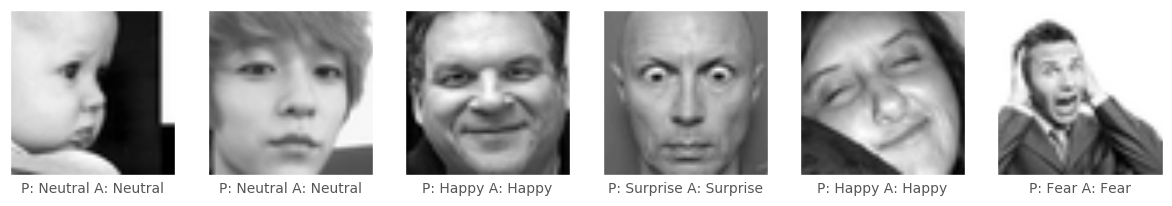

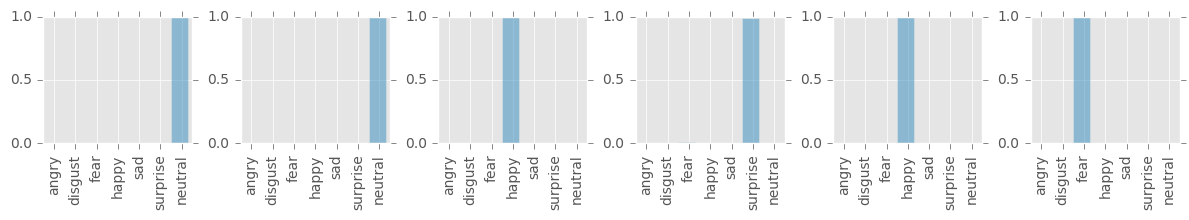

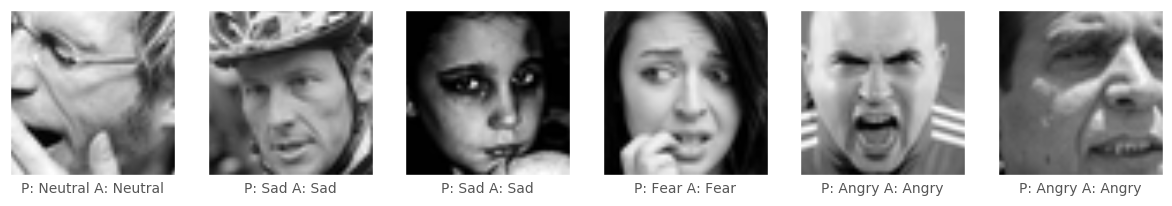

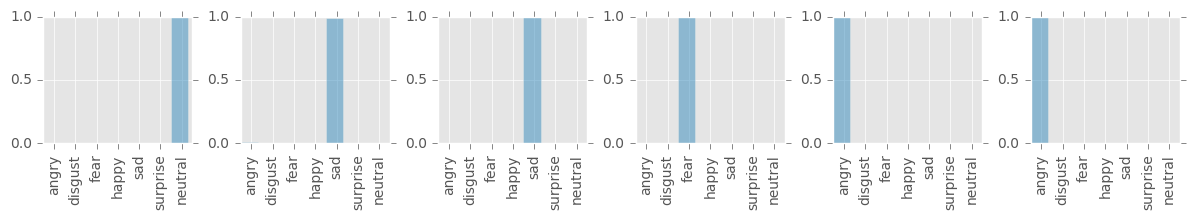

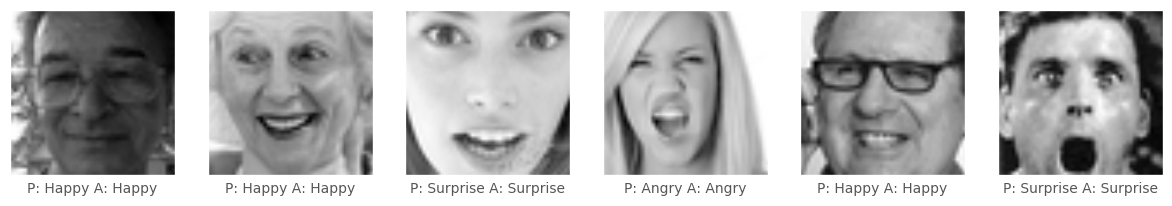

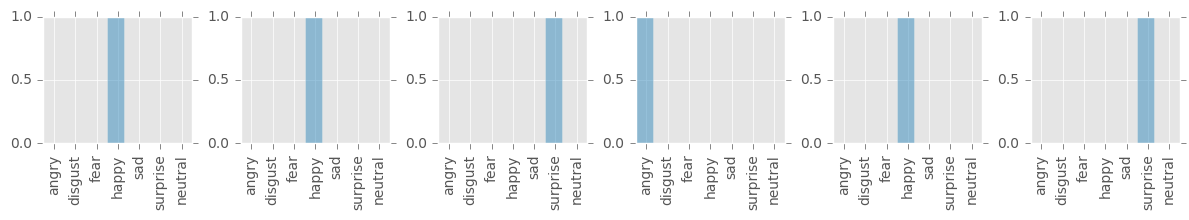

In [202]:
plot_subjects_with_probs(0, 36, y_prob)

# Plot the distribution of Predicted vs True

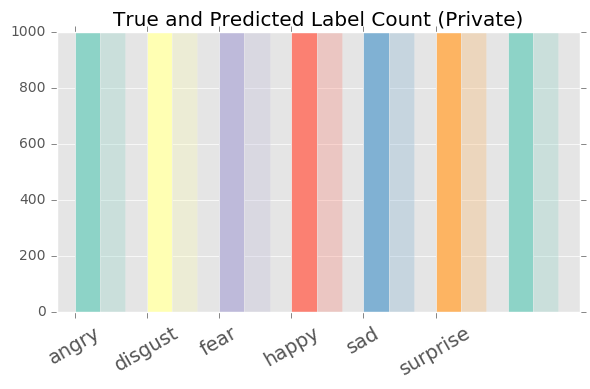

In [221]:
labels = ['angry', 'disgust','fear', 'happy', 'sad', 'surprise', 'neutral']
def plot_distribution(y_true, y_pred):
    ind = np.arange(1.5,8,1)  # the x locations for the groups
    width = 0.35   
    fig, ax = plt.subplots()
    true = ax.bar(ind, np.bincount(y_true), width, color=set3, alpha=1.0)
    pred = ax.bar(ind + width, np.bincount(y_pred), width, color=set3, alpha=0.3)
    ax.set_xticks(np.arange(1.5,7,1))
    ax.set_xticklabels(labels, rotation=30, fontsize=14)
    ax.set_xlim([1.25, 8.5])
    ax.set_ylim([0, 1000])
    ax.set_title('True and Predicted Label Count (Private)')
    plt.tight_layout()
    plt.show()

plot_distribution(y_true, y_pred)

# Confusion Matrix

In [223]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6,6))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0,7):
        for j in range(0,7):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    # ax.set_title('Confusion Matrix')
    ticks = np.arange(len(labels))
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

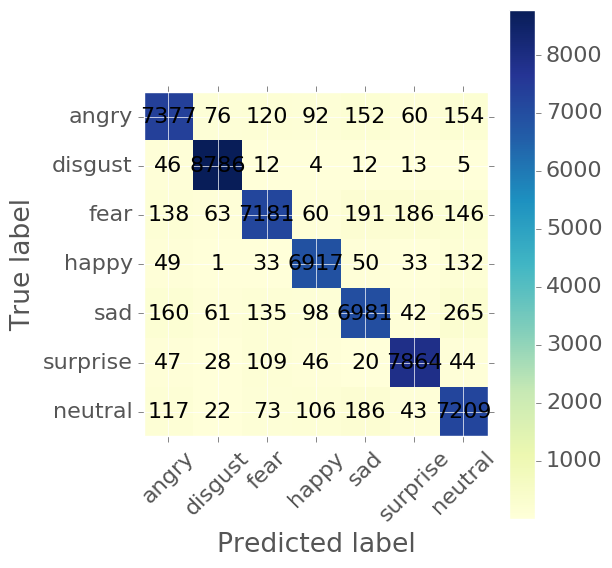

In [224]:
plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.YlGnBu)

# Classification Matrix

In [229]:
def class_precision(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    col = [cm[j,i] for j in range(0,len(labels))]
    return float(col[i])/sum(col)

def class_recall(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    row = [cm[i,j] for j in range(0,len(labels))]
    return float(row[i])/sum(row)

def class_accuracy(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    tp = cm[i,i]
    fn = sum([cm[i,j] for j in range(0,6) if j != i])
    fp = sum([cm[j,i] for j in range(0,6) if j != i])
    tn = sum([cm[i,j] for j in range(0,6) for i in range(0,6)]) -(tp+fp+fn)
    return float(tp + tn)/sum([tp, fn, fp, tn])

In [230]:
# private test set
for emotion in labels:
    print(emotion.upper())
    print('   acc = {}'.format(class_accuracy(y_true, y_pred, emotion)))
    print('  prec = {}'.format(class_precision(y_true, y_pred, emotion)))
    print('recall = {}\n'.format(class_recall(y_true, y_pred, emotion)))

ANGRY
   acc = 0.9801028723832103
  prec = 0.929795815477691
recall = 0.9185655584609638

DISGUST
   acc = 0.9933111783756323
  prec = 0.9722252960053115
recall = 0.9896373056994818

FEAR
   acc = 0.9778379865800224
  prec = 0.9371003523424246
recall = 0.9015693659761457

HAPPY
   acc = 0.9901361048197617
  prec = 0.9445582411579954
recall = 0.9586971586971587

SAD
   acc = 0.9805050483669538
  prec = 0.9195205479452054
recall = 0.901704985791785

SURPRISE
   acc = 0.9876383802891434
  prec = 0.9542531246207985
recall = 0.9639617553321893

NEUTRAL
   acc = 0.9726308659483944
  prec = 0.9062225015713388
recall = 0.9294739556472409



In [232]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=labels))

             precision    recall  f1-score   support

      angry       0.93      0.92      0.92      8031
    disgust       0.97      0.99      0.98      8878
       fear       0.94      0.90      0.92      7965
      happy       0.94      0.96      0.95      7215
        sad       0.92      0.90      0.91      7742
   surprise       0.95      0.96      0.96      8158
    neutral       0.91      0.93      0.92      7756

avg / total       0.94      0.94      0.94     55745



# Visualize the Keras Layers

In [256]:
# https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer

from keras import backend as K

def layers_overview(images):
    total_rows = len(images)
    fig = plt.figure(figsize=(8,10))
    idx = 0
    for i, row in df.iterrows():
        input_img = img
        ax = fig.add_subplot(16,12,idx+1)
        ax.imshow(input_img, cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
        idx += 1
    plt.show()

def get_layer_outputs(img, use_dropout):
    test_image = img
    outputs    = [layer.output for layer in model.layers]          # all layer outputs
    comp_graph = [K.function([model.input]+ [K.learning_phase()], [output]) for output in outputs]  # evaluation functions

    # Testing
    dropout = 1 if use_dropout else 0
    layer_outputs_list = [op([test_image, dropout]) for op in comp_graph]
    layer_outputs = []

    for layer_output in layer_outputs_list:
        print(layer_output[0][0].shape, end='\n-------------------\n')
        layer_outputs.append(layer_output[0][0])

    return layer_outputs

def plot_layer_outputs(img, layer_number, use_dropout):    
    layer_outputs = get_layer_outputs(img, use_dropout)

    x_max = layer_outputs[layer_number].shape[0]
    y_max = layer_outputs[layer_number].shape[1]
    n     = layer_outputs[layer_number].shape[2]

    L = []
    for i in range(n):
        L.append(np.zeros((x_max, y_max)))

    for i in range(n):
        for x in range(x_max):
            for y in range(y_max):
                L[i][x][y] = layer_outputs[layer_number][x][y][i]


#     for img in L:
#         plt.figure(figsize=(2, 2))
#         plt.imshow(img, interpolation='nearest', cmap='gray')
    layers_overview(L)

(46, 46, 64)
-------------------
(23, 23, 64)
-------------------
(23, 23, 64)
-------------------
(21, 21, 128)
-------------------
(10, 10, 128)
-------------------
(10, 10, 128)
-------------------
(8, 8, 256)
-------------------
(4, 4, 256)
-------------------
(4, 4, 256)
-------------------
(2, 2, 512)
-------------------
(1, 1, 512)
-------------------
(1, 1, 512)
-------------------
(1, 1, 512)
-------------------
(512,)
-------------------
(256,)
-------------------
(256,)
-------------------
(256,)
-------------------
(7,)
-------------------
(7,)
-------------------


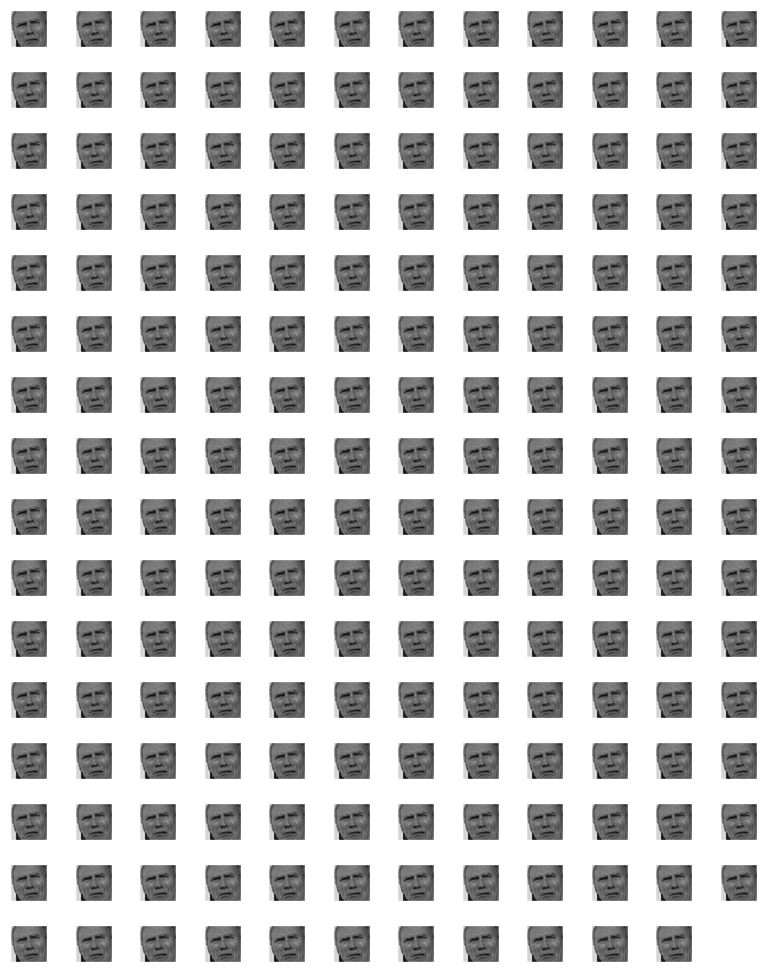

In [257]:
test_img = [testData[0]]
plot_layer_outputs(np.array(test_img), 2, use_dropout=False)